# Importing Libraries

In [ ]:
import re
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime, timedelta
from urllib.parse import urlparse
import email.utils
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from scipy.sparse import hstack

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset



pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Reading the Enron Emails CSV file

In [ ]:
df = pd.read_csv("/kaggle/input/enron-emails-dataset/Enron_Emails.csv")

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
df.head()

,file_path,from,to,subject,date,cc,bcc,body,url
0,/kaggle/input/raw-enron-dataset/maildir/neal-s...,matt.motsinger@enron.com,"hunter.shively@enron.com, phillip.allen@enron....",Average EOL and NON-EOL deals per day,"Mon, 19 Jun 2000 08:29:00 -0700 (PDT)","jeffrey.gossett@enron.com, brent.price@enron.c...","jeffrey.gossett@enron.com, brent.price@enron.c...","As requested by Jeff Shankman, here are the av...",NaN
1,/kaggle/input/raw-enron-dataset/maildir/neal-s...,scott.neal@enron.com,kmurra1@lsu.edu,Re: update,"Tue, 6 Mar 2001 03:41:00 -0800 (PST)",NaN,NaN,"Also, send me a copy of your resume. thanks.\...",NaN
2,/kaggle/input/raw-enron-dataset/maildir/neal-s...,scott.neal@enron.com,jana.giovannini@enron.com,Re: Analyst request,"Wed, 4 Oct 2000 10:20:00 -0700 (PDT)",NaN,NaN,Thank you for sending. \n\n\n \n\t\n\t\n\tF...,NaN
3,/kaggle/input/raw-enron-dataset/maildir/neal-s...,scott.neal@enron.com,oscar_harrison@msdw.com,Re: Christmas Wish,"Wed, 13 Dec 2000 12:24:00 -0800 (PST)",NaN,NaN,Merry Christmas to you and your family. We ha...,NaN
4,/kaggle/input/raw-enron-dataset/maildir/neal-s...,scott.neal@enron.com,john.shoobridge@enron.com,Re: Dinner,"Wed, 28 Feb 2001 01:55:00 -0800 (PST)",NaN,NaN,"yes. call me later. also, my cellular phone ...",NaN


# Nan values

In [ ]:
summary = pd.DataFrame({
    "Column": df.columns,
    "Nan count": df.isna().sum(),
})

print(summary)


              Column  Nan count
file_path  file_path          0
from            from          0
to                to      21847
subject      subject      19187
date            date          0
cc                cc     389520
bcc              bcc     389520
body            body          0
url              url     450273


# Dropping duplicates and filling missing values

In [ ]:
df.drop_duplicates(inplace = True)
df["to"] = df["to"].fillna("")
df["subject"] = df["subject"].fillna("")

# Function to parse date text and cycle encode it

In [ ]:
def parse_date_text(date_str):
    month_map = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
    }

    weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

    date_str = str(date_str).strip().lower()

    # Default values
    weekday = day = month = year = hour = minute = second = None

    # --- Extract weekday ---
    if len(date_str) >= 3:
        weekday_str = date_str[:3].title()
        weekday = weekdays.index(weekday_str) if weekday_str in weekdays else None

    # --- Extract numeric date ---
    match = re.search(r'(\d{1,2})\s+([a-z]{3})\s+(\d{4})', date_str)
    if match:
        day = int(match.group(1))
        month = month_map.get(match.group(2), None)
        year = int(match.group(3))

    # --- Extract time ---
    match_time = re.search(r'(\d{2}):(\d{2})(?::(\d{2}))?', date_str)
    if match_time:
        hour = int(match_time.group(1))
        minute = int(match_time.group(2))
        second = int(match_time.group(3)) if match_time.group(3) else 0

    # --- Cyclical encoding ---
    def cyclical(val, max_val):
        return np.sin(2 * np.pi * val / max_val), np.cos(2 * np.pi * val / max_val)

    weekday_sin, weekday_cos = cyclical(weekday, 7)
    day_sin, day_cos = cyclical(day, 31)
    month_sin, month_cos = cyclical(month, 12)
    hour_sin, hour_cos = cyclical(hour, 24)
    minute_sin, minute_cos = cyclical(minute, 60)
    second_sin, second_cos = cyclical(second, 60)

    return pd.Series([
        weekday_sin, weekday_cos,
        day_sin, day_cos,
        month_sin, month_cos,
        hour_sin, hour_cos,
        minute_sin, minute_cos,
        second_sin, second_cos,
        year  # keep year as-is
    ], index=[
        'weekday_sin', 'weekday_cos',
        'day_sin', 'day_cos',
        'month_sin', 'month_cos',
        'hour_sin', 'hour_cos',
        'minute_sin', 'minute_cos',
        'second_sin', 'second_cos',
        'year'
    ])


In [ ]:
df[['weekday_sin' , 'weekday_cos',
    'day_sin' , 'day_cos',
    'month_sin' , 'month_cos',
    'hour_sin' , 'hour_cos',
    'minute_sin' , 'minute_cos',
    'second_sin' , 'second_cos',
    'year']] = df['date'].apply(parse_date_text)

# Imortant keywords/phrases lists

In [ ]:
URGENT_KEYWORDS = [
    "urgent" , "urgently" , "immediately" , "immediate" , "immediate action" ,
    "respond immediately" , "important" , "high importance" , "high priority" ,
    "priority" , "action required" , "act now" , "respond now" , "asap" ,
    "verify now" , "confirm now" , "update now" , "review now" ,
    "expire" , "expires" , "expires today" , "expiring soon" , "last warning" ,
    "limited time" , "within 24 hours" , "within 48 hours" , "within hours" ,
    "time is running out" , "offer expires" , "today only" ,
    "urgent response needed" , "critical update" , "attention required" ,
    "final reminder" , "final warning" , "immediate response needed" ,
    "deadline" , "due today" , "due now" , "time-sensitive" , "time sensitive" ,
    "respond asap" , "quickly" , "fast action required" , "take action now" ,
    "do this immediately" , "important notice" , "emergency action" ,
    "critical issue" , "must act now" , "respond without delay" ,
    "urgent attention" , "requires immediate action"
]

THREAT_KEYWORDS = [
    "suspend" , "suspended" , "locked" , "locked out" , "close your account" ,
    "account closure" , "legal action" , "legal notice" , "final notice" ,
    "termination" , "deactivate" , "deactivation" , "restricted" , "restriction" ,
    "blocked" , "frozen" , "compromised" , "breach" , "security breach" ,
    "hacked" , "unauthorized" , "unauthorized access" , "unusual activity" ,
    "violation" , "policy violation" , "will be closed" , "forced closure" ,
    "take action or" , "lose access" , "permanently removed" ,
    "account disabled" , "security suspension" , "threat detected" ,
    "security risk" , "security warning" , "final attempt" , "failure to respond" ,
    "account will be terminated" , "forced deactivation" , "breach detected" ,
    "critical security issue" , "account compromised" , "service interruption" ,
    "security alert" , "high-risk login" , "multiple failed attempts"
]

MONEY_PRIZE_KEYWORDS = [
    "win" , "winner" , "won" , "prize" , "grand prize" , "cash" , "cash prize" ,
    "reward" , "bonus" , "lottery" , "jackpot" , "million" , "million dollars" ,
    "refund" , "tax refund" , "tax rebate" , "rebate" , "unclaimed" ,
    "compensation" , "inheritance" , "beneficiary" , "grant" , "funds" ,
    "payment released" , "claim your" , "claim now" , "redeem now" ,
    "congratulations you" , "free money" , "you've been selected" ,
    "$$$" , "financial award" , "monetary reward" , "payout" , "transfer" ,
    "urgent refund" , "deposit available" , "funds available" ,
    "cash transfer" , "unexpected funds" , "reward waiting" , "prize awaiting" ,
    "selected as winner" , "lucky draw" , "special payout" ,
    "exclusive reward" , "free bonus" , "instant winnings"
]

URGENCY_PHRASES = [
    "act now" , "don't wait" , "hurry" , "last chance" , "time is running out" ,
    "offer expires" , "today only" , "now or never" , "don't miss out" ,
    "limited offer" , "limited-time" , "while supplies last" ,
    "urgent response needed" , "expires soon" , "limited time" , "dont miss" ,
    "final opportunity" , "respond quickly" , "immediate attention required" ,
    "before it’s too late" , "claim before expiry" ,
    "offer ends soon" , "only hours left" , "only today" ,
    "limited quantity" , "final hours" , "respond before deadline"
]

GENERIC_SUSPICIOUS = [
    "click here" , "click below" , "click link" , "open link" , "login" ,
    "log in" , "update" , "update account" , "verify" , "verify your" ,
    "confirm" , "confirm your" , "validate" , "review" , "reactivate" ,
    "re-activate" , "password" , "security alert" , "dear customer" ,
    "dear user" , "valued customer" , "account holder" , "update payment" ,
    "billing information" , "payment method" , "credit card" , "card details" ,
    "reset password" , "identity verification" , "authentication required" ,
    "verify immediately" , "important update" , "account review" ,
    "confirm identity" , "provide details" , "submit information" ,
    "resolve issue" , "confirm account" , "login required" ,
    "reset your account" , "unlock account" , "secure login" ,
    "update credentials" , "verification process" , "restore access" ,
    "protect your account" , "account verification"
]

COMPANY_IMPERSONATION = [
    "paypal" , "amazon" , "apple" , "microsoft" , "google" , "facebook" ,
    "instagram" , "twitter" , "linkedin" , "bank" , "irs" , "fedex" , "usps" ,
    "ups" , "dhl" , "netflix" , "ebay" , "ssa" , "social security" ,
    "wells fargo" , "chase" , "bank of america" , "citibank" , "hsbc" ,
    "capital one" , "barclays" , "royal mail" , "revolut" , "stripe" ,
    "coinbase" , "binance" , "mcdonalds" , "spotify" , "icloud" ,
    "adobe" , "dropbox" , "onedrive" , "office365" , "outlook" , "teams" ,
    "zoho" , "intuit" , "quickbooks" ,
    "amazon support" , "microsoft support" , "google security" ,
    "bank security" , "visa" , "mastercard" , "amex" ,
    "national lottery" , "telecom" , "azure" , "aws" , "gmail team" ,
    "facebook security"
]

SPOOFING_INDICATORS = [
    "noreply" , "no-reply" , "donotreply" , "do-not-reply" ,
    "support@" , "admin@" , "security@" , "verification@" , "alert@" ,
    "service@" , "info@" , "notification@" , "update@" , "mailer@" , "robot@" ,
    "support-team@" , "supportdesk@" , "helpdesk@" , "accounts@" ,
    "billing@" , "customerservice@" , "compliance@" , "system@" , "system-mail@" ,
    "alerts@" , "noreplymail@" , "auto-mailer@" , "webmaster@" , "it-support@"
]

CREDENTIAL_REQUESTS = [
    "enter your password" , "provide your password" , "confirm password" ,
    "password" , "username and password" , "username" , "user id" ,
    "social security number" , "ssn" , "account number" , "credit card" ,
    "credit card number" , "card details" , "cvv" , "pin number" , "pin" ,
    "date of birth" , "dob" , "mother's maiden name" , "security question" ,
    "full name and address" , "bank details" , "routing number" ,
    "id card" , "passport number" , "driver license" , "two-factor code" ,
    "otp" , "one-time password" , "authentication code" , "verify identity" ,
    "enter your credentials" , "provide login details" , "reauthenticate" ,
    "input verification code" , "enter 2fa code" , "banking password" ,
    "enter digits" , "identity confirmation" , "submit credentials"
]

FREE_EMAIL_DOMAINS = [
    "gmail.com" , "yahoo.com" , "hotmail.com" , "outlook.com" , "aol.com" ,
    "mail.com" , "protonmail.com" , "yandex.com" , "gmx.com" , "icloud.com" ,
    "live.com" , "msn.com" , "inbox.com" , "fastmail.com" , "zoho.com" ,
    "hushmail.com" , "tutanota.com" , "yahoo.co.uk" , "outlook.co.uk" ,
    "hotmail.co.uk" , "googlemail.com" , "mail.ru" , "gmx.net" ,
    "yandex.ru" , "usa.com" , "europe.com"
]

personal_pronouns = [
    " i " , " me " , " myself " , " my " , " mine " ,
    " you " , " your " , " yours " , " yourself " , " yourselves " ,
    " we " , " us " , " our " , " ours " , " ourselves " ,
    " he " , " him " , " his " , " himself " ,
    " she " , " her " , " hers " , " herself " ,
    " they " , " them " , " their " , " theirs " , " themselves " ,
    " i'm " , " you're " , " we're " , " they're " ,
    " i'd " , " you'd " , " we'd " , " they'd " ,
    " i'll " , " you'll " , " we'll " , " they'll " ,
    " i've " , " you've " , " we've " , " they've " ,
    " u " , " ur " , " im " , " id " , " youll " , " weve " ,
    " ya " , " u r " , " u're "
]

action_words = [
    "click here" , "verify now" , "update now" , "confirm now" , "act now" ,
    "login" , "log in" , "sign in" , "sign-in" , "reset password" ,
    "unlock account" , "reactivate account" , "open attachment" ,
    "open file" , "download" , "run file" , "install" , "enable macros" ,
    "enable content" , "open this link" , "visit link" , "review document" ,
    "access portal" , "complete form" , "submit info" , "submit information" ,
    "provide details" , "authorize" , "approve request" , "authenticate" ,
    "verify identity" , "take action" , "respond now" , "reply now" ,
    "urgent action required" , "redeem now" , "claim reward" , "claim prize" ,
    "claim bonus" , "authenticate now" , "fix account" , "resolve issue" ,
    "update details" , "check status" , "check your account" , "security check" ,
    "identity check" , "invoice due" , "payment required" , "confirm payment" ,
    "review invoice" , "download invoice" , "open invoice" , "final warning" ,
    "last notice" , "immediate attention" , "time-sensitive" , "expires today" ,
    "expires soon" , "within 24 hours" , "within 48 hours" , "verify details" ,
    "confirm identity" , "update credentials" , "reactivate immediately" ,
    "urgent verification" , "review activity" ,
    "review payment" , "open secure message" , "open secure file" ,
    "download secure document" , "complete verification" ,
    "follow instructions" , "press the button" , "tap to verify" ,
    "accept request" , "approve payment" , "review balance"
]

attachment_keywords = [
    "attached" , "attachment" , "find attached" , "see attached" , "enclosed" ,
    "included" , "attached file" , "attached document" , "attached invoice" ,
    "file" , "document" , "invoice" , "statement" , "report" , "form" , "pdf" ,
    "doc" , "docx" , "xls" , "xlsx" , "ppt" , "pptx" , "zip" , "rar" , "7z" , "tar" ,
    "gz" , "invoice.pdf" , "statement.pdf" , "payment.docx" , "document.pdf" ,
    "remittance.pdf" , "receipt.pdf" , "scan.pdf" , "scanned document" ,
    "secure document" , "protected file" , "important file" ,
    "download attachment" , "download file" , "open document" , "open report" ,
    "review attachment" , "package attached" ,
    "secure pdf" , "encrypted file" , "password-protected file" ,
    "confidential document" , "urgent document" , "delivery note" ,
    "shipping label" , "invoice copy" , "wire details" , "account statement"
]

common_misspellings = [
    "urgnet" , "accout" , "pasword" , "verifiy" , "confirim" , "securty" ,
    "recieve" , "bussiness" , "offical" , "adress" , "addres" , "identiy" ,
    "identitiy" , "authenticaion" , "updatte" , "verfication" , "verificatoin" ,
    "verifiction" , "logn" , "loggin" , "loggin in" , "passwrod" , "paswrod" ,
    "pssword" , "confrim" , "confim" , "confurm" , "securrity" , "securitty" ,
    "acount" , "acoount" , "accuont" , "accoubt" , "acc0unt" , "passw0rd" ,
    "ver1fy" , "conf1rm" , "secur1ty" , "verlfy" , "veriry" , "authentlcate" ,
    "l0gin" , "resp0nd" , "paymnet" , "invocie" , "docuemnt" , "statment" ,
    "recipt" , "notcie" , "activatoin" , "restircted" , "suspened" , "prizee" ,
    "reawrd" , "bannk" , "accuont" , "micorsoft" , "microsofft" ,
    "protction" , "verificaiton" , "confurmation" , "identificatoin" ,
    "autheticatoin" ,
    "passowrd" , "passworld" , "loggin" , "verifcation" , "immediatly" ,
    "urjent" , "supension" , "restrction" , "invoie" , "documant" ,
    "statemant" , "bankk" , "paymnent" , "invocie" , "accpunt" ,
    "vaccant" , "authentcation"
]

# Feature extraction function

In [ ]:
def extract_features(df):
    features_df = df.copy()

    subject_lower = features_df["subject"].astype(str).str.lower()
    body_lower = features_df["body"].astype(str).str.lower()
    from_lower = features_df["from"].astype(str).str.lower()

    url_col = "url" if "url" in features_df.columns else "urls"
    urls_lower = features_df[url_col].fillna("").astype(str).str.lower()
    url_str_col = features_df[url_col].fillna("").astype(str)

    features_df["has_cc"] = (~features_df["cc"].isna()).astype(int)
    features_df["has_bcc"] = (~features_df["bcc"].isna()).astype(int)
    features_df["has_url"] = (~features_df[url_col].isna()).astype(int)

    features_df["cc_count"] = features_df["cc"].fillna("").astype(str).apply(
        lambda x: len([e for e in re.split(r"[,;]", x) if "@" in e])
    )
    features_df["bcc_count"] = features_df["bcc"].fillna("").astype(str).apply(
        lambda x: len([e for e in re.split(r"[,;]", x) if "@" in e])
    )

    features_df["total_recipients"] = features_df["cc_count"] + features_df["bcc_count"] + 1
    features_df["is_mass_email"] = (features_df["total_recipients"] > 5).astype(int)

    features_df["subject_length"] = features_df["subject"].astype(str).apply(len)
    features_df["subject_word_count"] = features_df["subject"].astype(str).apply(lambda x: len(x.split()))

    features_df["subject_urgent_keywords"] = subject_lower.apply(
        lambda x: sum(1 for kw in URGENT_KEYWORDS if kw in x)
    )
    features_df["subject_threat_keywords"] = subject_lower.apply(
        lambda x: sum(1 for kw in THREAT_KEYWORDS if kw in x)
    )
    features_df["subject_money_keywords"] = subject_lower.apply(
        lambda x: sum(1 for kw in MONEY_PRIZE_KEYWORDS if kw in x)
    )
    features_df["subject_generic_keywords"] = subject_lower.apply(
        lambda x: sum(1 for kw in GENERIC_SUSPICIOUS if kw in x)
    )
    features_df["subject_company_keywords"] = subject_lower.apply(
        lambda x: sum(1 for kw in COMPANY_IMPERSONATION if kw in x)
    )

    features_df["subject_excessive_punctuation"] = features_df["subject"].astype(str).apply(
        lambda x: int(bool(re.search(r"!{2,}|\?{2,}|\${2,}", x)))
    )
    features_df["subject_exclamation_count"] = features_df["subject"].astype(str).apply(lambda x: x.count("!"))
    features_df["subject_question_count"] = features_df["subject"].astype(str).apply(lambda x: x.count("?"))
    features_df["subject_dollar_count"] = features_df["subject"].astype(str).apply(lambda x: x.count("$"))

    features_df["subject_all_caps_ratio"] = features_df["subject"].astype(str).apply(
        lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0
    )
    features_df["subject_has_re_fwd"] = subject_lower.apply(
        lambda x: int(bool(re.match(r"^(re:|fw:|fwd:)", x)))
    )

    features_df["sender_is_freemail"] = from_lower.apply(
        lambda x: int(any(dom in x for dom in FREE_EMAIL_DOMAINS))
    )
    features_df["sender_has_numbers"] = features_df["from"].astype(str).apply(
        lambda x: int(bool(re.search(r"\d" , x)))
    )
    features_df["sender_number_count"] = features_df["from"].astype(str).apply(
        lambda x: len(re.findall(r"\d" , x))
    )
    features_df["sender_length"] = features_df["from"].astype(str).apply(len)

    features_df["sender_has_spoofing_indicator"] = from_lower.apply(
        lambda x: int(any(indicator in x for indicator in SPOOFING_INDICATORS))
    )

    features_df["sender_multiple_separators"] = features_df["from"].astype(str).apply(
        lambda x: int(bool(re.search(r"\.{2,}|-{2,}|_{2,}", x)))
    )

    features_df["body_length"] = features_df["body"].astype(str).apply(len)
    features_df["body_word_count"] = features_df["body"].astype(str).apply(lambda x: len(x.split()))

    features_df["body_urgent_keywords"] = body_lower.apply(
        lambda x: sum(1 for kw in URGENT_KEYWORDS if kw in x)
    )
    features_df["body_threat_keywords"] = body_lower.apply(
        lambda x: sum(1 for kw in THREAT_KEYWORDS if kw in x)
    )
    features_df["body_money_keywords"] = body_lower.apply(
        lambda x: sum(1 for kw in MONEY_PRIZE_KEYWORDS if kw in x)
    )
    features_df["body_generic_keywords"] = body_lower.apply(
        lambda x: sum(1 for kw in GENERIC_SUSPICIOUS if kw in x)
    )
    features_df["body_company_keywords"] = body_lower.apply(
        lambda x: sum(1 for kw in COMPANY_IMPERSONATION if kw in x)
    )
    features_df["body_urgency_phrases"] = body_lower.apply(
        lambda x: sum(1 for phrase in URGENCY_PHRASES if phrase in x)
    )
    features_df["body_credential_requests"] = body_lower.apply(
        lambda x: sum(1 for kw in CREDENTIAL_REQUESTS if kw in x)
    )

    features_df["body_excessive_punctuation"] = features_df["body"].astype(str).apply(
        lambda x: int(bool(re.search(r"!{2,}|\?{2,}|\${2,}" , x)))
    )
    features_df["body_exclamation_count"] = features_df["body"].astype(str).apply(lambda x: x.count("!"))
    features_df["body_question_count"] = features_df["body"].astype(str).apply(lambda x: x.count("?"))
    features_df["body_dollar_count"] = features_df["body"].astype(str).apply(lambda x: x.count("$"))

    features_df["body_has_html"] = features_df["body"].astype(str).apply(
        lambda x: int(bool(re.search(r"<[^>]+>" , x)))
    )

    features_df["body_has_misspellings"] = body_lower.apply(
        lambda x: int(any(word in x for word in common_misspellings))
    )

    features_df["url_count"] = url_str_col.apply(
        lambda x: len(re.findall(r"https?://" , x))
    )

    shorteners = ["bit.ly" , "tinyurl" , "goo.gl" , "t.co" , "ow.ly" , "is.gd" , "buff.ly"]
    features_df["url_is_shortened"] = urls_lower.apply(
        lambda x: int(any(short in x for short in shorteners))
    )

    features_df["url_avg_length"] = url_str_col.apply(
        lambda x: sum(len(url) for url in re.findall(r"https?://[^\s]+", x)) / max(1 , len(re.findall(r"https?://" , x)))
    )

    features_df["url_many_subdomains"] = url_str_col.apply(
        lambda x: int(any(len(re.findall(r"\." , url.split("/")[2])) > 3
                         for url in re.findall(r"https?://[^\s]+" , x) if "/" in url))
    )

    features_df["url_has_at_symbol"] = url_str_col.apply(
        lambda x: int("@" in x and "http" in x)
    )

    features_df["sender_company_mismatch"] = (
        (features_df["sender_is_freemail"] == 1) &
        ((features_df["subject_company_keywords"] > 0) |
         (features_df["body_company_keywords"] > 0))
    ).astype(int)

    features_df["total_urgent_keywords"] = features_df["subject_urgent_keywords"] + features_df["body_urgent_keywords"]
    features_df["total_threat_keywords"] = features_df["subject_threat_keywords"] + features_df["body_threat_keywords"]
    features_df["total_money_keywords"] = features_df["subject_money_keywords"] + features_df["body_money_keywords"]
    features_df["total_generic_keywords"] = features_df["subject_generic_keywords"] + features_df["body_generic_keywords"]
    features_df["total_company_keywords"] = features_df["subject_company_keywords"] + features_df["body_company_keywords"]

    features_df["urgent_keyword_ratio"] = features_df["total_urgent_keywords"] / (features_df["body_word_count"] + 1)
    features_df["threat_keyword_ratio"] = features_df["total_threat_keywords"] / (features_df["body_word_count"] + 1)
    features_df["money_keyword_ratio"] = features_df["total_money_keywords"] / (features_df["body_word_count"] + 1)
    features_df["generic_keyword_ratio"] = features_df["total_generic_keywords"] / (features_df["body_word_count"] + 1)

    features_df["url_to_text_ratio"] = features_df["url_count"] / (features_df["body_word_count"] + 1)

    features_df["is_reply_or_forward"] = features_df["subject_has_re_fwd"]

    features_df["avg_word_length"] = features_df["body"].astype(str).apply(
        lambda x: sum(len(word) for word in x.split()) / max(1 , len(x.split()))
    )

    features_df["body_uppercase_ratio"] = features_df["body"].astype(str).apply(
        lambda x: sum(1 for c in x if c.isupper()) / max(1 , len(x))
    )

    features_df["body_special_char_count"] = features_df["body"].astype(str).apply(
        lambda x: len(re.findall(r"[^a-zA-Z0-9\s]" , x))
    )

    features_df["mentions_attachment"] = body_lower.apply(
        lambda x: int(any(kw in x for kw in attachment_keywords))
    )

    features_df["body_personal_pronoun_count"] = body_lower.apply(
        lambda x: sum(1 for pronoun in personal_pronouns if pronoun in " " + x + " ")
    )

    features_df["body_action_request_count"] = body_lower.apply(
        lambda x: sum(1 for action in action_words if action in x)
    )

    features_df["has_signature"] = body_lower.apply(
        lambda x: int(bool(re.search(r"(regards|sincerely|best wishes|thanks|thank you)" , x)))
    )

    features_df["body_has_phone"] = features_df["body"].astype(str).apply(
        lambda x: int(bool(re.search(r"\b\d{3}[-.]?\d{3}[-.]?\d{4}\b" , x)))
    )

    features_df["body_is_very_short"] = (features_df["body_word_count"] < 10).astype(int)

    features_df["subject_body_overlap"] = features_df.apply(
        lambda row: len(set(str(row["subject"]).lower().split()) &
                       set(str(row["body"]).lower().split())) /
                   max(1 , len(str(row["subject"]).split())),
        axis = 1
    )

    features_df["link_text_no_url"] = (
        (features_df["url_count"] == 0) &
        (body_lower.apply(lambda x: "click" in x or "link" in x or "http" in x))
    ).astype(int)

    return features_df


# Dataframe with extracted features

In [ ]:
engineered_df = extract_features(df)

In [ ]:
subset = engineered_df.iloc[: , :]
value_counts_dict = {col: subset[col].value_counts() for col in subset.columns}

counter = 0
for col , counts in value_counts_dict.items():
    print(f"Index: {counter}")
    print(f"Column: {counts.head(5)}")
    print("-" * 40)
    print()
    counter += 1


Index: 0
Column: file_path
/kaggle/input/raw-enron-dataset/maildir/keavey-p/discussion_threads/347.    1
/kaggle/input/raw-enron-dataset/maildir/neal-s/eol/1.                       1
/kaggle/input/raw-enron-dataset/maildir/neal-s/all_documents/205.           1
/kaggle/input/raw-enron-dataset/maildir/neal-s/all_documents/414.           1
/kaggle/input/raw-enron-dataset/maildir/neal-s/all_documents/301.           1
Name: count, dtype: int64
----------------------------------------

Index: 1
Column: from
kay.mann@enron.com          16735
vince.kaminski@enron.com    14368
jeff.dasovich@enron.com     11411
pete.davis@enron.com         9149
chris.germany@enron.com      8801
Name: count, dtype: int64
----------------------------------------

Index: 2
Column: to
                             21847
pete.davis@enron.com          9155
tana.jones@enron.com          5677
sara.shackleton@enron.com     4974
vkaminski@aol.com             4870
Name: count, dtype: int64
----------------------------------

In [ ]:
engineered_df.head()

,file_path,from,to,subject,date,cc,bcc,body,url,weekday_sin,weekday_cos,day_sin,day_cos,month_sin,month_cos,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,year,has_cc,has_bcc,has_url,cc_count,bcc_count,total_recipients,is_mass_email,subject_length,subject_word_count,subject_urgent_keywords,subject_threat_keywords,subject_money_keywords,subject_generic_keywords,subject_company_keywords,subject_excessive_punctuation,subject_exclamation_count,subject_question_count,subject_dollar_count,subject_all_caps_ratio,subject_has_re_fwd,sender_is_freemail,sender_has_numbers,sender_number_count,sender_length,sender_has_spoofing_indicator,sender_multiple_separators,body_length,body_word_count,body_urgent_keywords,body_threat_keywords,body_money_keywords,body_generic_keywords,body_company_keywords,body_urgency_phrases,body_credential_requests,body_excessive_punctuation,body_exclamation_count,body_question_count,body_dollar_count,body_has_html,body_has_misspellings,url_count,url_is_shortened,url_avg_length,url_many_subdomains,url_has_at_symbol,sender_company_mismatch,total_urgent_keywords,total_threat_keywords,total_money_keywords,total_generic_keywords,total_company_keywords,urgent_keyword_ratio,threat_keyword_ratio,money_keyword_ratio,generic_keyword_ratio,url_to_text_ratio,is_reply_or_forward,avg_word_length,body_uppercase_ratio,body_special_char_count,mentions_attachment,body_personal_pronoun_count,body_action_request_count,has_signature,body_has_phone,body_is_very_short,subject_body_overlap,link_text_no_url
0,/kaggle/input/raw-enron-dataset/maildir/neal-s...,matt.motsinger@enron.com,"hunter.shively@enron.com, phillip.allen@enron....",Average EOL and NON-EOL deals per day,"Mon, 19 Jun 2000 08:29:00 -0700 (PDT)","jeffrey.gossett@enron.com, brent.price@enron.c...","jeffrey.gossett@enron.com, brent.price@enron.c...","As requested by Jeff Shankman, here are the av...",NaN,0.000000,1.000000,-0.651372,-0.758758,1.224647e-16,-1.000000e+00,8.660254e-01,-0.500000,0.104528,-0.994522,0.0,1.0,2000.0,1,1,0,5,5,11,1,37,7,0,0,0,0,0,0,0,0,0,0.270270,0,0,0,0,24,0,0,451,75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0.000,0.0,0.000,0.00000,0.0,0,4.880000,0.053215,12,1,1,0,0,0,0,0.857143,0
1,/kaggle/input/raw-enron-dataset/maildir/neal-s...,scott.neal@enron.com,kmurra1@lsu.edu,Re: update,"Tue, 6 Mar 2001 03:41:00 -0800 (PST)",NaN,NaN,"Also, send me a copy of your resume. thanks.\...",NaN,0.781831,0.623490,0.937752,0.347305,1.000000e+00,6.123234e-17,7.071068e-01,0.707107,-0.913545,-0.406737,0.0,1.0,2001.0,0,0,0,0,0,1,0,10,2,0,0,0,1,0,0,0,0,0,0.100000,1,0,0,0,20,0,0,1815,311,0,0,0,1,1,0,1,0,4,0,0,1,0,0,0,0.0,0,0,0,0,0,0,2,1,0.000,0.0,0.000,0.00641,0.0,1,4.736334,0.041322,87,1,12,0,1,0,0,0.500000,0
2,/kaggle/input/raw-enron-dataset/maildir/neal-s...,scott.neal@enron.com,jana.giovannini@enron.com,Re: Analyst request,"Wed, 4 Oct 2000 10:20:00 -0700 (PDT)",NaN,NaN,Thank you for sending. \n\n\n \n\t\n\t\n\tF...,NaN,0.974928,-0.222521,0.724793,0.688967,-8.660254e-01,5.000000e-01,5.000000e-01,-0.866025,0.866025,-0.500000,0.0,1.0,2000.0,0,0,0,0,0,1,0,19,3,0,0,0,0,0,0,0,0,0,0.105263,1,0,0,0,20,0,0,1181,154,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0.000,0.0,0.000,0.00000,0.0,1,5.915584,0.119390,160,0,8,0,1,0,0,0.666667,0
3,/kaggle/input/raw-enron-dataset/maildir/neal-s...,scott.neal@enron.com,oscar_harrison@msdw.com,Re: Christmas Wish,"Wed, 13 Dec 2000 12:24:00 -0800 (PST)",NaN,NaN,Merry Christmas to you and your family. We ha...,NaN,0.974928,-0.222521,0.485302,-0.874347,-2.449294e-16,1.000000e+00,1.224647e-16,-1.000000,0.587785,-0.809017,0.0,1.0,2000.0,0,0,0,0,0,1,0,18,3,0,0,0,0,0,0,0,0,0,0.166667,1,0,0,0,20,0,0,848,124,2,0,2,0,1,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,2,0,2,0,1,0.016,0.0,0.016,0.00000,0.0,1,5.685484,0.043632,86,0,4,1,0,0,0,0.666667,0
4,/kaggle/input/raw-enron-dataset/maildir/neal-s...,scott.neal@enron.com,john.shoobridge@enron.com,Re: Dinner,"Wed, 28 Feb 2001 01:55:00 -0800 (PST)",NaN,NaN,"yes. call me later. also, my cellular phon

# TF-IDF on mail subject and body

In [ ]:
tfidf_subject = TfidfVectorizer(
    max_features = 100,
    min_df = 100,
    max_df = 0.5,
    stop_words = "english"
)
X_subject = tfidf_subject.fit_transform(engineered_df["subject"])

subject_weight = 2
X_subject_weighted = X_subject * subject_weight

df_subject_tfidf = pd.DataFrame(
    X_subject_weighted.toarray(),
    columns = [f"subj_{w}" for w in tfidf_subject.get_feature_names_out()],
    index = engineered_df.index
)

tfidf_body = TfidfVectorizer(
    max_features = 300,
    min_df = 100,
    max_df = 0.5,
    stop_words = "english"
)
X_body = tfidf_body.fit_transform(engineered_df["body"])

df_body_tfidf = pd.DataFrame(
    X_body.toarray(),
    columns = [f"body_{w}" for w in tfidf_body.get_feature_names_out()],
    index = engineered_df.index
)

# Merging TF-IDf values with engineered_df

In [ ]:
engineered_df = pd.concat([engineered_df , df_subject_tfidf , df_body_tfidf] , axis = 1)

In [ ]:
engineered_df.head()

,file_path,from,to,subject,date,cc,bcc,body,url,weekday_sin,weekday_cos,day_sin,day_cos,month_sin,month_cos,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,year,has_cc,has_bcc,has_url,cc_count,bcc_count,total_recipients,is_mass_email,subject_length,subject_word_count,subject_urgent_keywords,subject_threat_keywords,subject_money_keywords,subject_generic_keywords,subject_company_keywords,subject_excessive_punctuation,subject_exclamation_count,subject_question_count,subject_dollar_count,subject_all_caps_ratio,subject_has_re_fwd,sender_is_freemail,sender_has_numbers,sender_number_count,sender_length,sender_has_spoofing_indicator,sender_multiple_separators,body_length,body_word_count,body_urgent_keywords,body_threat_keywords,body_money_keywords,body_generic_keywords,body_company_keywords,body_urgency_phrases,body_credential_requests,body_excessive_punctuation,body_exclamation_count,body_question_count,body_dollar_count,body_has_html,body_has_misspellings,url_count,url_is_shortened,url_avg_length,url_many_subdomains,url_has_at_symbol,sender_company_mismatch,total_urgent_keywords,total_threat_keywords,total_money_keywords,total_generic_keywords,total_company_keywords,urgent_keyword_ratio,threat_keyword_ratio,money_keyword_ratio,generic_keyword_ratio,url_to_text_ratio,is_reply_or_forward,avg_word_length,body_uppercase_ratio,body_special_char_count,mentions_attachment,body_personal_pronoun_count,body_action_request_count,has_signature,body_has_phone,body_is_very_short,subject_body_overlap,link_text_no_url,subj_00,subj_01,subj_02,subj_10,subj_11,subj_12,subj_15,subj_19,subj_20,subj_2000,subj_2001,subj_2002,subj_21,subj_23,subj_30,subj_access,subj_agreement,subj_agreements,subj_announcement,subj_approval,subj_ca,subj_california,subj_capacity,subj_change,subj_changes,subj_codesite,subj_com,subj_company,subj_conference,subj_confirmation,subj_contract,subj_corp,subj_credit,subj_daily,subj_data,subj_date,subj_day,subj_deal,subj_deals,subj_december,subj_draft,subj_ena,subj_energy,subj_enron,subj_enrononline,subj_eol,subj_ferc,subj_final,subj_friday,subj_fw,subj_fwd,subj_gas,subj_group,subj_hour,subj_hourahead,subj_houston,subj_info,subj_information,subj_isda,subj_issues,subj_lay,subj_legal,subj_letter,subj_list,subj_management,subj_market,subj_master,subj_meeting,subj_new,subj_news,subj_notice,subj_notification,subj_november,subj_october,subj_office,subj_order,subj_outage,subj_plan,subj_power,subj_presentation,subj_price,subj_project,subj_report,subj_request,subj_review,subj_revised,subj_risk,subj_schedule,subj_services,subj_start,subj_status,subj_summary,subj_time,subj_today,subj_trading,subj_tw,subj_update,subj_week,subj_weekend,subj_weekly,body_00,body_000,body_01,body_02,body_03,body_04,body_05,body_06,body_07,body_08,body_09,body_10,body_11,body_12,body_13,body_14,body_15,body_16,body_17,body_18,body_19,body_20,body_2000,body_2001,body_2002,body_21,body_22,body_23,body_24,body_25,body_26,body_27,body_28,body_29,body_30,body_31,body_50,body_713,body_853,body_able,body_access,body_additional,body_address,body_agreement,body_america,body_aol,body_april,body_asp,body_attached,body_available,body_based,body_best,body_billion,body_board,body_br,body_business,body_buy,body_ca,body_california,body_capacity,body_cc,body_center,body_change,body_changes,body_chris,body_class,body_click,body_com,body_come,body_comments,body_commission,body_committee,body_communications,body_companies,body_company,body_conference,body_contact,body_contract,body_contracts,body_copy,body_corp,body_cost,body_credit,body_current,body_customers,body_daily,body_data,body_date,body_david,body_davis,body_day,body_days,body_deal,body_deals,body_december,body_did,body_discuss,body_doc,body_does,body_don,body_draft,body_ect,body_ees,body_electric,body_electricity,body_email,body_employees,body_ena,body_end,body_energy,body_enron,body_enron_development,body_enronxgate,body_error,body_et,body_fax,body_ferc,body_file,body_final,body_financial,body_firm,body_following

In [ ]:
len(engineered_df.columns)

491

# Rule based system for possible phishing threats labeling(as close as possible to real life values)

In [ ]:
def auto_phishing_label(row):
    score = 0

    score += 5 * row.get("body_credential_requests" , 0)
    score += 4 * row.get("sender_company_mismatch" , 0)
    score += 4 * row.get("url_has_ip" , 0)
    score += 3 * row.get("total_threat_keywords" , 0)
    score += 2 * row.get("total_urgent_keywords" , 0)
    score += 2 * row.get("body_urgency_phrases" , 0)
    score += 3 * row.get("total_money_keywords" , 0)
    score += 2 * row.get("url_is_shortened" , 0)
    score += 2 * row.get("url_many_subdomains" , 0)
    score += 3 * row.get("url_has_at_symbol" , 0)

    avg_len = row.get("url_avg_length" , 0)
    if avg_len > 100:
        score += 2
    elif avg_len < 15 and row.get("url_count" , 0) > 0:
        score += 1

    if row.get("url_to_text_ratio" , 0) > 0.5:
        score += 2

    score += 2 * row.get("sender_has_spoofing_indicator" , 0)
    score += 1 * row.get("sender_is_freemail" , 0)
    score += 1 * row.get("sender_multiple_separators" , 0)

    if row.get("sender_number_count" , 0) > 3:
        score += 2
    elif row.get("sender_has_numbers" , 0):
        score += 1

    sender_len = row.get("sender_length" , 0)
    if sender_len < 8 or sender_len > 60:
        score += 1

    score += 1 * row.get("total_generic_keywords" , 0)

    if row.get("subject_excessive_punctuation" , 0):
        score += 1
    if row.get("body_excessive_punctuation" , 0):
        score += 1

    score += min(row.get("subject_exclamation_count" , 0) , 3)
    score += min(row.get("body_exclamation_count" , 0) , 3)
    score += min(row.get("subject_dollar_count" , 0) , 2)
    score += min(row.get("body_dollar_count" , 0) , 2)

    caps = row.get("subject_all_caps_ratio" , 0)
    if caps > 0.6:
        score += 2
    elif caps > 0.3:
        score += 1

    if row.get("urgent_keyword_ratio" , 0) > 0.05:
        score += 2
    if row.get("threat_keyword_ratio" , 0) > 0.03:
        score += 2
    if row.get("money_keyword_ratio" , 0) > 0.03:
        score += 2

    threshold = 18

    return 1 if score >= threshold else 0


In [ ]:
engineered_df["possible_phishing"] = engineered_df.apply(auto_phishing_label , axis = 1)

In [ ]:
engineered_df[engineered_df["possible_phishing"] == 1].head()

,file_path,from,to,subject,date,cc,bcc,body,url,weekday_sin,weekday_cos,day_sin,day_cos,month_sin,month_cos,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,year,has_cc,has_bcc,has_url,cc_count,bcc_count,total_recipients,is_mass_email,subject_length,subject_word_count,subject_urgent_keywords,subject_threat_keywords,subject_money_keywords,subject_generic_keywords,subject_company_keywords,subject_excessive_punctuation,subject_exclamation_count,subject_question_count,subject_dollar_count,subject_all_caps_ratio,subject_has_re_fwd,sender_is_freemail,sender_has_numbers,sender_number_count,sender_length,sender_has_spoofing_indicator,sender_multiple_separators,body_length,body_word_count,body_urgent_keywords,body_threat_keywords,body_money_keywords,body_generic_keywords,body_company_keywords,body_urgency_phrases,body_credential_requests,body_excessive_punctuation,body_exclamation_count,body_question_count,body_dollar_count,body_has_html,body_has_misspellings,url_count,url_is_shortened,url_avg_length,url_many_subdomains,url_has_at_symbol,sender_company_mismatch,total_urgent_keywords,total_threat_keywords,total_money_keywords,total_generic_keywords,total_company_keywords,urgent_keyword_ratio,threat_keyword_ratio,money_keyword_ratio,generic_keyword_ratio,url_to_text_ratio,is_reply_or_forward,avg_word_length,body_uppercase_ratio,body_special_char_count,mentions_attachment,body_personal_pronoun_count,body_action_request_count,has_signature,body_has_phone,body_is_very_short,subject_body_overlap,link_text_no_url,subj_00,subj_01,subj_02,subj_10,subj_11,subj_12,subj_15,subj_19,subj_20,subj_2000,subj_2001,subj_2002,subj_21,subj_23,subj_30,subj_access,subj_agreement,subj_agreements,subj_announcement,subj_approval,subj_ca,subj_california,subj_capacity,subj_change,subj_changes,subj_codesite,subj_com,subj_company,subj_conference,subj_confirmation,subj_contract,subj_corp,subj_credit,subj_daily,subj_data,subj_date,subj_day,subj_deal,subj_deals,subj_december,subj_draft,subj_ena,subj_energy,subj_enron,subj_enrononline,subj_eol,subj_ferc,subj_final,subj_friday,subj_fw,subj_fwd,subj_gas,subj_group,subj_hour,subj_hourahead,subj_houston,subj_info,subj_information,subj_isda,subj_issues,subj_lay,subj_legal,subj_letter,subj_list,subj_management,subj_market,subj_master,subj_meeting,subj_new,subj_news,subj_notice,subj_notification,subj_november,subj_october,subj_office,subj_order,subj_outage,subj_plan,subj_power,subj_presentation,subj_price,subj_project,subj_report,subj_request,subj_review,subj_revised,subj_risk,subj_schedule,subj_services,subj_start,subj_status,subj_summary,subj_time,subj_today,subj_trading,subj_tw,subj_update,subj_week,subj_weekend,subj_weekly,body_00,body_000,body_01,body_02,body_03,body_04,body_05,body_06,body_07,body_08,body_09,body_10,body_11,body_12,body_13,body_14,body_15,body_16,body_17,body_18,body_19,body_20,body_2000,body_2001,body_2002,body_21,body_22,body_23,body_24,body_25,body_26,body_27,body_28,body_29,body_30,body_31,body_50,body_713,body_853,body_able,body_access,body_additional,body_address,body_agreement,body_america,body_aol,body_april,body_asp,body_attached,body_available,body_based,body_best,body_billion,body_board,body_br,body_business,body_buy,body_ca,body_california,body_capacity,body_cc,body_center,body_change,body_changes,body_chris,body_class,body_click,body_com,body_come,body_comments,body_commission,body_committee,body_communications,body_companies,body_company,body_conference,body_contact,body_contract,body_contracts,body_copy,body_corp,body_cost,body_credit,body_current,body_customers,body_daily,body_data,body_date,body_david,body_davis,body_day,body_days,body_deal,body_deals,body_december,body_did,body_discuss,body_doc,body_does,body_don,body_draft,body_ect,body_ees,body_electric,body_electricity,body_email,body_employees,body_ena,body_end,body_energy,body_enron,body_enron_development,body_enronxgate,body_error,body_et,body_fax,body_ferc,body_file,body_final,body_financial,body_firm,body_following

In [ ]:
print(f"Total emails: {len(engineered_df)}")
print(f"Phishing emails (class = 1): {(engineered_df['possible_phishing'] == 1).sum()}")
print(f"Legitimate emails (class = 0): {(engineered_df['possible_phishing'] == 0).sum()}")
print(f"\nPhishing rate: {engineered_df['possible_phishing'].mean() * 100:.2f}%")

Total emails: 517401
Phishing emails (class = 1): 21463
Legitimate emails (class = 0): 495938

Phishing rate: 4.15%


# Dropping unnecessary columns

In [ ]:
engineered_df.drop(["file_path" , "date" , "subject" ,	"from" , "to" , "cc" , "bcc" , "date" , "body" , "url"] , axis = 1 , inplace = True)

# Deleting the top percentage of outliers

In [ ]:
row_norms = np.linalg.norm(engineered_df , axis = 1)
outliers = np.where(row_norms > np.percentile(row_norms , 99.99))[0]
print("Outlier rows:" , outliers)

Outlier rows: [ 60721  63054  73518  76154 106732 107741 109708 115403 115431 115432
 139975 149669 150881 153109 154993 156174 156265 156743 157445 158021
 158328 161215 166661 166781 166796 167806 168250 168505 169443 170045
 170313 171012 172665 191440 206568 225424 291838 306646 424495 428497
 446147 446177 446220 446401 446488 446516 446531 446665 446673 446760
 513707 514849]


# Seperating normal columns from TF-IDf columns and dropping the possible_phising column for clustering

In [ ]:
engineered_df_clean = engineered_df.drop(index = outliers).reset_index(drop = True)

print("Original rows:" , engineered_df.shape[0])
print("Cleaned rows:" , engineered_df_clean.shape[0])

Original rows: 517401
Cleaned rows: 517349


In [ ]:
X_tfidf = engineered_df_clean.iloc[: , 81:]
X_other = engineered_df_clean.drop(columns = X_tfidf.columns)
X_tfidf.drop(["possible_phishing"] , axis = 1 , inplace = True)

# Scaling numerical features

In [ ]:
numeric_features = ["subject_length" , "subject_word_count" , "body_length" , "body_word_count" ,
                    "cc_count" , "bcc_count" , "total_recipients" , "sender_length" , "sender_number_count" ,
                    "subject_exclamation_count" , "subject_question_count" , "subject_dollar_count" ,
                    "body_exclamation_count" , "body_question_count" , "body_dollar_count" , "avg_word_length" ,
                    "url_count" , "url_avg_length" , "total_urgent_keywords" , "total_threat_keywords" ,
                    "total_money_keywords" , "total_generic_keywords" , "total_company_keywords"]

X_other_scaled = X_other.copy()
scaler = StandardScaler()
X_other_scaled[numeric_features] = scaler.fit_transform(X_other_scaled[numeric_features])

# Cross grid search for MiniBatchKMeans clustering + dimensionality reduction for TF-IDF columns through trunecated SVD

In [ ]:
svd_components_list = [80 , 100 , 120 , 150]
k_range = range(2 , 8)
batch_size = 2048
SAMPLE_SIZE = 50000

results = []

rng = np.random.default_rng(42)
sample_idx = rng.choice(X_tfidf.shape[0] , size = min(SAMPLE_SIZE , X_tfidf.shape[0]) , replace = False)

for n_comp in svd_components_list:
    print(f"\n{'=' * 80}")
    print(f"Testing SVD components: {n_comp}")
    print(f"{'=' * 80}")

    svd = TruncatedSVD(n_components = n_comp , random_state = 42)
    X_tfidf_reduced = svd.fit_transform(X_tfidf)

    X_combined = np.hstack([X_tfidf_reduced, X_other_scaled.values])
    X_sample = X_combined[sample_idx]

    for k in k_range:
        kmeans = MiniBatchKMeans(
            n_clusters = k,
            batch_size = batch_size,
            max_iter = 50,
            random_state = 42,
            n_init = 10,
            reassignment_ratio = 0.01,
            verbose = 0
        )
        labels_full = kmeans.fit_predict(X_combined)
        labels_sample = labels_full[sample_idx]

        unique, counts = np.unique(labels_sample , return_counts = True)
        n_clusters = len(unique)
        min_cluster_size = counts.min()
        max_cluster_size = counts.max()

        sil_score = silhouette_score(X_sample , labels_sample)
        db_score = davies_bouldin_score(X_sample , labels_sample)
        ch_score = calinski_harabasz_score(X_sample , labels_sample)
        inertia = kmeans.inertia_

        results.append({
            "svd_components" : n_comp,
            "k" : k,
            "n_clusters" : n_clusters,
            "min_cluster_size" : min_cluster_size,
            "max_cluster_size" : max_cluster_size,
            "silhouette" : sil_score,
            "davies_bouldin" : db_score,
            "calinski_harabasz" : ch_score,
            "inertia" : inertia
        })

        print(f"k = {k}: Inertia = {inertia:.2f} , Silhouette = {sil_score:.4f} , DB = {db_score:.4f}")


Testing SVD components: 80
k = 2: Inertia = 45485217512.83 , Silhouette = 0.8578 , DB = 0.7148
k = 3: Inertia = 23628012893.03 , Silhouette = 0.7582 , DB = 0.6063
k = 4: Inertia = 20027293156.32 , Silhouette = 0.6524 , DB = 0.6008
k = 5: Inertia = 23583201372.48 , Silhouette = 0.5535 , DB = 0.6130
k = 6: Inertia = 16408476236.00 , Silhouette = 0.4780 , DB = 0.6246
k = 7: Inertia = 16835102490.30 , Silhouette = 0.4239 , DB = 0.6713

Testing SVD components: 100
k = 2: Inertia = 45485330084.54 , Silhouette = 0.8578 , DB = 0.7148
k = 3: Inertia = 23628125407.70 , Silhouette = 0.7582 , DB = 0.6063
k = 4: Inertia = 20027405491.61 , Silhouette = 0.6523 , DB = 0.6008
k = 5: Inertia = 23583313520.46 , Silhouette = 0.5534 , DB = 0.6131
k = 6: Inertia = 16408269336.15 , Silhouette = 0.4777 , DB = 0.6249
k = 7: Inertia = 16835214430.07 , Silhouette = 0.4235 , DB = 0.6718

Testing SVD components: 120
k = 2: Inertia = 45485400321.17 , Silhouette = 0.8578 , DB = 0.7148
k = 3: Inertia = 23628195567.4

# Results and clustering scoring metrics viusalization


BEST CONFIGURATION (HIGHEST SILHOUETTE SCORE):
svd_components: 80.0000
k: 2.0000
n_clusters: 2.0000
min_cluster_size: 2702.0000
max_cluster_size: 47298.0000
silhouette: 0.8578
davies_bouldin: 0.7148
calinski_harabasz: 30522.2938
inertia: 45485217512.8305


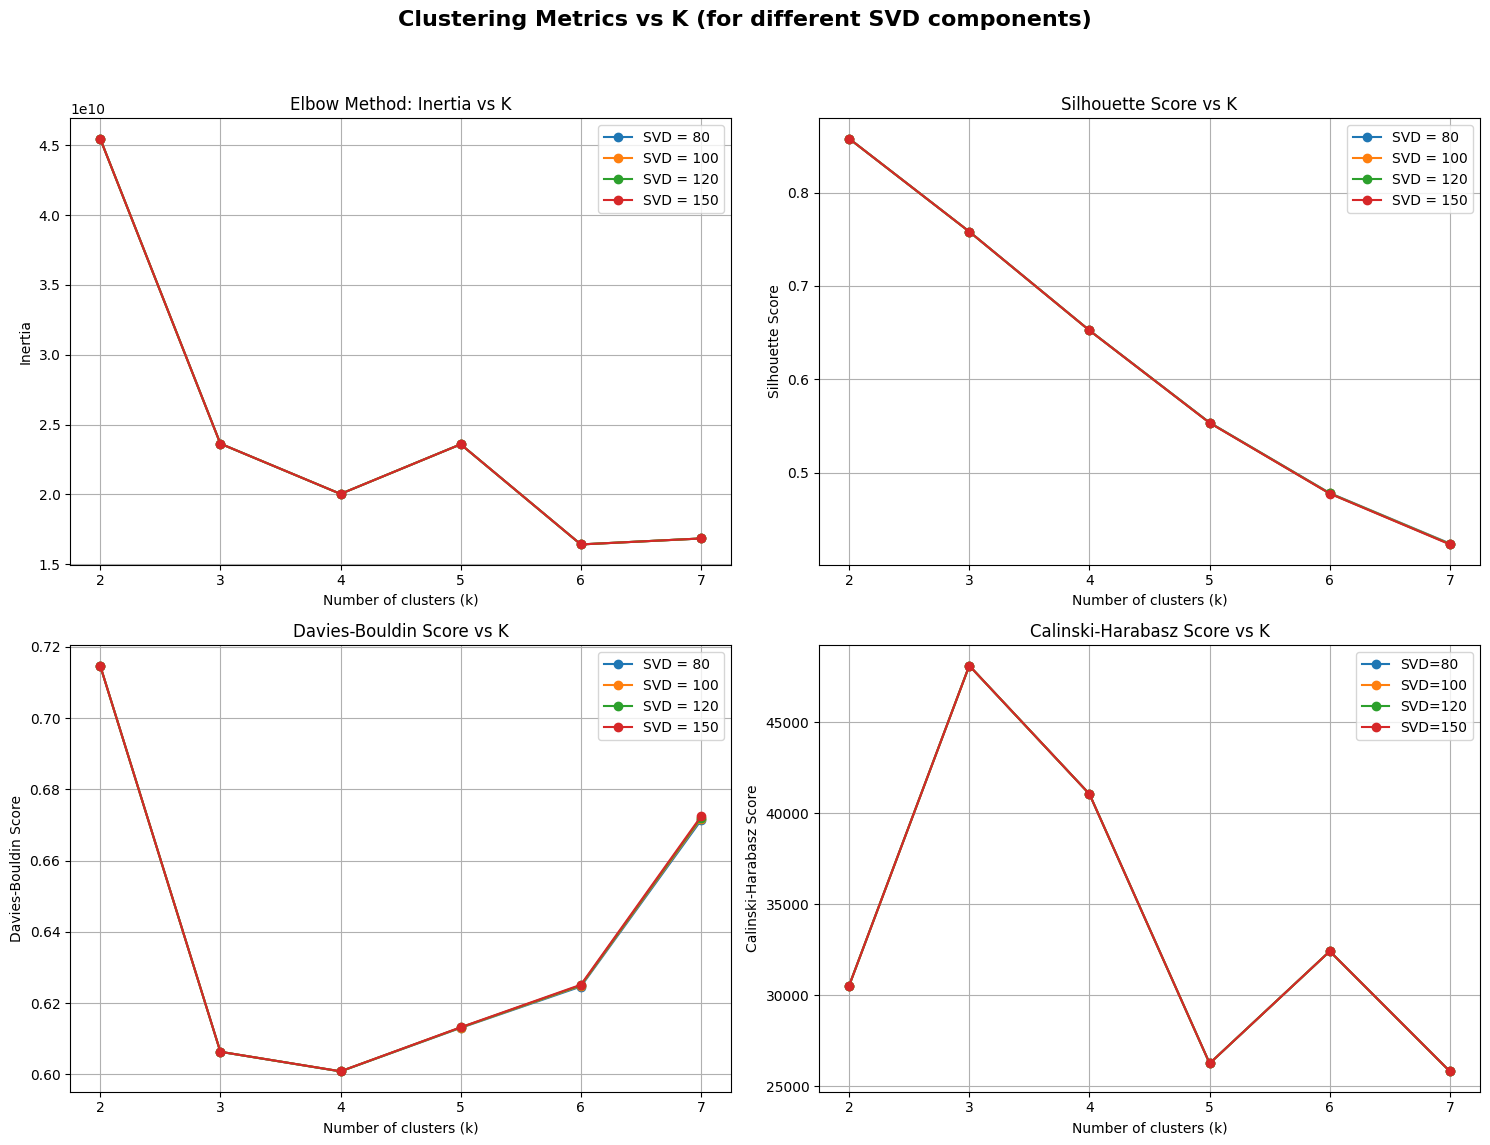

In [ ]:
results_df = pd.DataFrame(results)

best_idx = results_df["silhouette"].idxmax()
best_result = results_df.loc[best_idx]

print("\n" + "=" * 80)
print("BEST CONFIGURATION (HIGHEST SILHOUETTE SCORE):")
print("=" * 80)
for col in best_result.index:
    print(f"{col}: {best_result[col]:.4f}" if isinstance(best_result[col] , float) else f"{col}: {best_result[col]}")

import matplotlib.pyplot as plt

fig , axes = plt.subplots(2 , 2 , figsize = (15 , 12))
fig.suptitle("Clustering Metrics vs K (for different SVD components)" , fontsize = 16 , fontweight = "bold")

for n_comp in svd_components_list:
    subset = results_df[results_df["svd_components"] == n_comp]
    axes[0 , 0].plot(subset["k"] , subset["inertia"] , marker = "o" , label = f"SVD = {n_comp}")
axes[0 , 0].set_xlabel("Number of clusters (k)")
axes[0 , 0].set_ylabel("Inertia")
axes[0 , 0].set_title("Elbow Method: Inertia vs K")
axes[0 , 0].grid(True)
axes[0 , 0].legend()

for n_comp in svd_components_list:
    subset = results_df[results_df["svd_components"] == n_comp]
    axes[0 , 1].plot(subset["k"] , subset["silhouette"] , marker = "o" , label = f"SVD = {n_comp}")
axes[0 , 1].set_xlabel("Number of clusters (k)")
axes[0 , 1].set_ylabel("Silhouette Score")
axes[0 , 1].set_title("Silhouette Score vs K")
axes[0 , 1].grid(True)
axes[0 , 1].legend()

for n_comp in svd_components_list:
    subset = results_df[results_df["svd_components"] == n_comp]
    axes[1 , 0].plot(subset["k"] , subset["davies_bouldin"] , marker = "o" , label = f"SVD = {n_comp}")
axes[1 , 0].set_xlabel("Number of clusters (k)")
axes[1 , 0].set_ylabel("Davies-Bouldin Score")
axes[1 , 0].set_title("Davies-Bouldin Score vs K")
axes[1 , 0].grid(True)
axes[1 , 0].legend()

for n_comp in svd_components_list:
    subset = results_df[results_df["svd_components"] == n_comp]
    axes[1 , 1].plot(subset["k"] , subset["calinski_harabasz"] , marker = "o" , label = f"SVD={n_comp}")
axes[1 , 1].set_xlabel("Number of clusters (k)")
axes[1 , 1].set_ylabel("Calinski-Harabasz Score")
axes[1 , 1].set_title("Calinski-Harabasz Score vs K")
axes[1 , 1].grid(True)
axes[1 , 1].legend()

plt.tight_layout(rect = [0 , 0.03 , 1 , 0.95])
plt.show()

# Dimensionality reduction using truncated SVD

In [ ]:
svd = TruncatedSVD(n_components = 100, random_state = 42)
X_tfidf_reduced = svd.fit_transform(X_tfidf)

tfidf_cols = [f"tfidf_svd_{i}" for i in range(X_tfidf_reduced.shape[1])]
other_cols = X_other_scaled.columns.tolist()

X_combined = pd.DataFrame(
    np.hstack([X_tfidf_reduced , X_other_scaled.values]),
    index = X_other_scaled.index,
    columns = tfidf_cols + other_cols
)


# Final KMeans clustering based on MiniBatchKMeans clustering results

In [ ]:
k = 3
sil_sample_size = 50000

kmeans = KMeans(
    n_clusters = k,
    max_iter = 50,
    random_state = 42,
    n_init = 10
)

labels = kmeans.fit_predict(X_combined)

rng = np.random.default_rng(42)
sample_idx = rng.choice(X_combined.shape[0] , size = min(sil_sample_size , X_combined.shape[0]) , replace = False)
X_sample = X_combined.iloc[sample_idx]
labels_sample = labels[sample_idx]

sil_score = silhouette_score(X_sample , labels_sample)
db_score = davies_bouldin_score(X_combined , labels)
ch_score = calinski_harabasz_score(X_combined , labels)
inertia = kmeans.inertia_

unique , counts = np.unique(labels , return_counts = True)
cluster_sizes = dict(zip(unique , counts))

print(f"KMeans results with SVD = {100} , k={k}")
print(f"Inertia: {inertia:.2f}")
print(f"Silhouette score (sampled {len(sample_idx)} points): {sil_score:.4f}")
print(f"Davies-Bouldin score: {db_score:.4f}")
print(f"Calinski-Harabasz score: {ch_score:.2f}")
print(f"Cluster sizes: {cluster_sizes}")

KMeans results with SVD = 100 , k=3
Inertia: 18979073193.95
Silhouette score (sampled 50000 points): 0.8784
Davies-Bouldin score: 0.4885
Calinski-Harabasz score: 698455.31
Cluster sizes: {0: 501021, 1: 1231, 2: 15097}


# Phishing risk levels assignment

In [ ]:
X_combined["cluster"] = labels
Y = engineered_df_clean["possible_phishing"]

In [ ]:
phishing_counts = (engineered_df_clean.groupby(X_combined["cluster"])["possible_phishing"].sum())
cluster_counts = (X_combined["cluster"].value_counts().sort_index())


summary = pd.DataFrame({
    "total_in_cluster": cluster_counts,
    "phishing_in_cluster": phishing_counts,
    "phishing_rate": phishing_counts / cluster_counts
})

print(summary)

         total_in_cluster  phishing_in_cluster  phishing_rate
cluster                                                      
0                  501021                13411       0.026767
1                    1231                  981       0.796913
2                   15097                 7023       0.465192


# Data Undersampling for class imbalance

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("\nPerforming Undersampling...")
print(f"Original class distribution:\n{Y.value_counts()}")
print(f"Original imbalance ratio: {Y.value_counts()[0]/Y.value_counts()[1]:.2f}:1")

data = X_combined.copy()
data["target"] = Y.values

majority = data[data["target"] == 0]
minority = data[data["target"] == 1]

n_minority = len(minority)
majority_undersampled = resample(majority,
                                 replace=False,
                                 n_samples=n_minority * 2,
                                 random_state=42)

data_balanced = pd.concat([majority_undersampled, minority])
data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

X_balanced = data_balanced.drop("target", axis=1)
Y_balanced = data_balanced["target"]

print(f"\nBalanced class distribution:\n{Y_balanced.value_counts()}")
print(f"New imbalance ratio: {Y_balanced.value_counts()[0]/Y_balanced.value_counts()[1]:.2f}:1")


Using device: cuda

Performing Undersampling...
Original class distribution:
possible_phishing
0    495934
1     21415
Name: count, dtype: int64
Original imbalance ratio: 23.16:1

Balanced class distribution:
target
0    42830
1    21415
Name: count, dtype: int64
New imbalance ratio: 2.00:1


# Data splitting

In [ ]:
print("\nSplitting data")

X_train, X_test, y_train, y_test = train_test_split(X_balanced, Y_balanced, test_size  =0.2 , random_state = 42 , stratify = Y_balanced)
X_train, X_val, y_train, y_val = train_test_split(X_train , y_train , test_size = 0.2 , random_state = 42 , stratify = y_train)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

X_train_tensor = torch.FloatTensor(X_train.values).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1).to(device)
X_val_tensor = torch.FloatTensor(X_val.values).to(device)
y_val_tensor = torch.FloatTensor(y_val.values).unsqueeze(1).to(device)
X_test_tensor = torch.FloatTensor(X_test.values).to(device)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1).to(device)

train_dataset = TensorDataset(X_train_tensor , y_train_tensor)
val_dataset = TensorDataset(X_val_tensor , y_val_tensor)
test_dataset = TensorDataset(X_test_tensor , y_test_tensor)

train_loader = DataLoader(train_dataset , batch_size = 32 , shuffle = True)
val_loader = DataLoader(val_dataset , batch_size = 32 , shuffle = False)
test_loader = DataLoader(test_dataset , batch_size = 32 , shuffle = False)



Splitting data
Training set size: 41116
Validation set size: 10280
Test set size: 12849


# Neural Network architecture

In [ ]:
class PhishingDetector(nn.Module):
    def __init__(self, input_dim):
        super(PhishingDetector, self).__init__()

        # Layer 1: 256 neurons
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.4)

        # Layer 2: 128 neurons
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)

        # Layer 3: 64 neurons
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.3)

        # Layer 4: 32 neurons
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout4 = nn.Dropout(0.2)

        # Output layer
        self.fc5 = nn.Linear(32, 1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Layer 1
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        # Layer 2
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)

        # Layer 3
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)

        # Layer 4
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.dropout4(x)

        # Output
        x = self.fc5(x)
        x = self.sigmoid(x)

        return x

# Initializing model

In [ ]:
input_dim = X_train.shape[1]
model = PhishingDetector(input_dim).to(device)

print(f"\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")


Model Architecture:
PhishingDetector(
  (fc1): Linear(in_features=182, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (bn4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc5): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Total parameters: 91,073


# Optimizer and loss function set-up

In [ ]:
print("\nSetting up optimizer and loss function")
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                                   patience=5, verbose=True)


Setting up optimizer and loss function


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Taining and validating functions

In [ ]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch , y_batch in loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        y_batch = y_batch.squeeze()
        loss = criterion(outputs , y_batch)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions = (outputs > 0.5).float()
        correct += (predictions == y_batch).sum().item()
        total += y_batch.size(0)

    return total_loss / len(loader) , correct / total

def validate(model , loader , criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch).squeeze()
            y_batch = y_batch.squeeze()
            loss = criterion(outputs , y_batch)

            total_loss += loss.item()
            predictions = (outputs > 0.5).float()
            correct += (predictions == y_batch).sum().item()
            total += y_batch.size(0)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())

    return total_loss / len(loader) , correct / total , all_preds , all_labels , all_probs


# Model training

In [ ]:
print("\nTraining model")
print("=" * 60)

n_epochs = 30
best_val_loss = float("inf")
patience = 4
patience_counter = 0

history = {
    "train_loss": [] , "train_acc": [],
    "val_loss": [] , "val_acc": []
}

for epoch in range(n_epochs):
    train_loss , train_acc = train_epoch(model , train_loader , criterion , optimizer)
    val_loss , val_acc , _ , _ , _ = validate(model , val_loader , criterion)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    scheduler.step(val_loss)

    print(f"Epoch {epoch + 1} / {n_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict() , "best_phishing_model.pth")
        print(f"  → Model improved! Saved to 'best_phishing_model.pth'")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch + 1} epochs")
            break



Training model
Epoch 1 / 30 - Train Loss: 0.1995, Train Acc: 0.9248 - Val Loss: 0.7862, Val Acc: 0.7727
  → Model improved! Saved to 'best_phishing_model.pth'
Epoch 2 / 30 - Train Loss: 0.1495, Train Acc: 0.9425 - Val Loss: 0.7838, Val Acc: 0.7687
  → Model improved! Saved to 'best_phishing_model.pth'
Epoch 3 / 30 - Train Loss: 0.1382, Train Acc: 0.9479 - Val Loss: 0.1086, Val Acc: 0.9789
  → Model improved! Saved to 'best_phishing_model.pth'
Epoch 4 / 30 - Train Loss: 0.1340, Train Acc: 0.9494 - Val Loss: 0.1061, Val Acc: 0.9626
  → Model improved! Saved to 'best_phishing_model.pth'
Epoch 5 / 30 - Train Loss: 0.1389, Train Acc: 0.9466 - Val Loss: 0.0824, Val Acc: 0.9732
  → Model improved! Saved to 'best_phishing_model.pth'
Epoch 6 / 30 - Train Loss: 0.1356, Train Acc: 0.9481 - Val Loss: 0.2280, Val Acc: 0.8836
Epoch 7 / 30 - Train Loss: 0.1322, Train Acc: 0.9502 - Val Loss: 0.1931, Val Acc: 0.9079
Epoch 8 / 30 - Train Loss: 0.1356, Train Acc: 0.9473 - Val Loss: 0.0923, Val Acc: 0.97

# Loading the best model

In [ ]:
model.load_state_dict(torch.load("best_phishing_model.pth"))

<All keys matched successfully>

# Model testing and evaluation

In [ ]:
print("\n" + "=" * 60)
print("FINAL EVALUATION ON TEST SET")
print("=" * 60)

test_loss, test_acc, y_pred, y_true, y_probs = validate(model , test_loader , criterion)

from sklearn.metrics import precision_score , recall_score , f1_score , roc_auc_score , classification_report , confusion_matrix

precision = precision_score(y_true , y_pred)
recall = recall_score(y_true , y_pred)
f1 = f1_score(y_true , y_pred)
auc = roc_auc_score(y_true , y_probs)

print(f"\nTest Accuracy:  {test_acc:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall:    {recall:.4f}")
print(f"Test F1-Score:  {f1:.4f}")
print(f"Test AUC-ROC:   {auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_true , y_pred , target_names = ["Legitimate" , "Phishing"]))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_true , y_pred)
print(cm)



FINAL EVALUATION ON TEST SET

Test Accuracy:  0.9730
Test Precision: 0.9276
Test Recall:    0.9967
Test F1-Score:  0.9609
Test AUC-ROC:   0.9973

Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      0.96      0.98      8566
    Phishing       0.93      1.00      0.96      4283

    accuracy                           0.97     12849
   macro avg       0.96      0.98      0.97     12849
weighted avg       0.97      0.97      0.97     12849


Confusion Matrix:
[[8233  333]
 [  14 4269]]


# Visualization


Creating visualizations...
Results saved to 'phishing_nn_results.png'


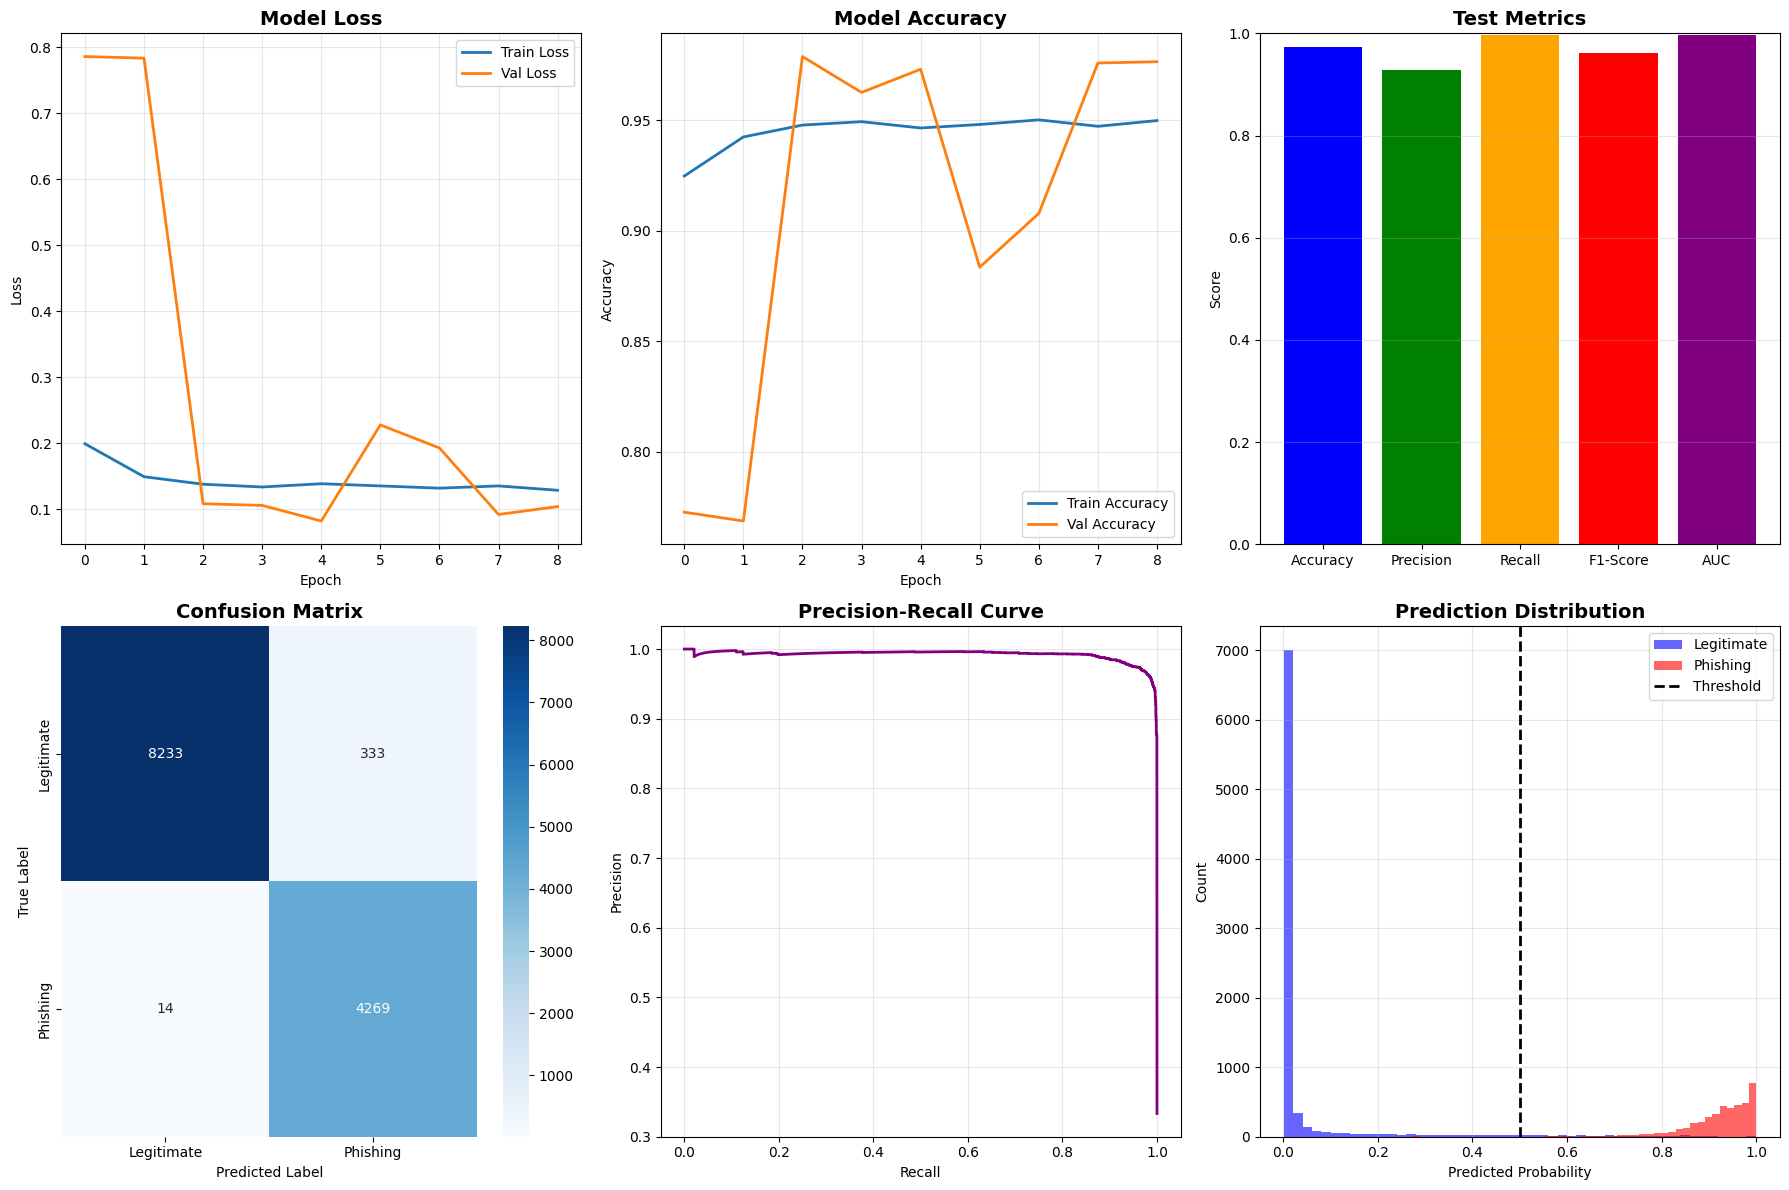

In [ ]:
print("\nCreating visualizations:")

fig , axes = plt.subplots(2 , 3, figsize = (18 , 12))

axes[0 , 0].plot(history["train_loss"] , label = "Train Loss" , linewidth = 2)
axes[0 , 0].plot(history["val_loss"] , label = "Val Loss" , linewidth = 2)
axes[0 , 0].set_title("Model Loss" , fontsize = 14 , fontweight = "bold")
axes[0 , 0].set_xlabel("Epoch")
axes[0 , 0].set_ylabel("Loss")
axes[0 , 0].legend()
axes[0 , 0].grid(True , alpha = 0.3)

axes[0 , 1].plot(history["train_acc"] , label = "Train Accuracy" , linewidth = 2)
axes[0 , 1].plot(history["val_acc"] , label = "Val Accuracy" , linewidth = 2)
axes[0 , 1].set_title("Model Accuracy" , fontsize = 14 , fontweight = "bold")
axes[0 , 1].set_xlabel("Epoch")
axes[0 , 1].set_ylabel("Accuracy")
axes[0 , 1].legend()
axes[0 , 1].grid(True , alpha = 0.3)

metrics = ["Accuracy" , "Precision" , "Recall" , "F1-Score" , "AUC"]
values = [test_acc , precision , recall , f1 , auc]
axes[0 , 2].bar(metrics , values , color = ["blue" , "green" , "orange" , "red" , "purple"])
axes[0 , 2].set_title("Test Metrics" , fontsize = 14 , fontweight = "bold")
axes[0 , 2].set_ylabel("Score")
axes[0 , 2].set_ylim([0 , 1])
axes[0 , 2].grid(True , alpha = 0.3 , axis = "y")

sns.heatmap(cm , annot = True , fmt = "d" , cmap = "Blues" , ax = axes[1 , 0] , xticklabels = ["Legitimate" , "Phishing"] , yticklabels = ["Legitimate" , "Phishing"])
axes[1 , 0].set_title("Confusion Matrix" , fontsize = 14 , fontweight = "bold")
axes[1 , 0].set_ylabel("True Label")
axes[1 , 0].set_xlabel("Predicted Label")

precision_vals , recall_vals , _ = precision_recall_curve(y_true , y_probs)
axes[1 , 1].plot(recall_vals , precision_vals , linewidth = 2, color = "purple")
axes[1 , 1].set_title("Precision-Recall Curve" , fontsize = 14 , fontweight = "bold")
axes[1 , 1].set_xlabel("Recall")
axes[1 , 1].set_ylabel("Precision")
axes[1 , 1].grid(True , alpha = 0.3)

y_true_array = np.array(y_true)
y_probs_array = np.array(y_probs)
axes[1 , 2].hist(y_probs_array[y_true_array == 0] , bins = 50 , alpha = 0.6 , label = "Legitimate" , color="blue")
axes[1 , 2].hist(y_probs_array[y_true_array == 1] , bins = 50 , alpha = 0.6 , label = "Phishing" , color = "red")
axes[1 , 2].axvline(x = 0.5 , color = "black" , linestyle = "--" , linewidth = 2 , label = "Threshold")
axes[1 , 2].set_title("Prediction Distribution" , fontsize = 14 , fontweight = "bold")
axes[1 , 2].set_xlabel("Predicted Probability")
axes[1 , 2].set_ylabel("Count")
axes[1 , 2].legend()
axes[1 , 2].grid(True , alpha=0.3)

plt.tight_layout()
plt.savefig("phishing_nn_results.png" , dpi = 300 , bbox_inches = "tight")
print("Results saved to 'phishing_nn_results.png'")
plt.show()


In [ ]:
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

class PhishingDetectionPipeline:

    def __init__(self):
        self.tfidf_subject = None
        self.tfidf_body = None
        self.scaler = None
        self.svd = None
        self.kmeans = None
        self.model = None
        self.subject_weight = 2
        self.numeric_features = [
            "subject_length", "subject_word_count", "body_length", "body_word_count",
            "cc_count", "bcc_count", "total_recipients", "sender_length", "sender_number_count",
            "subject_exclamation_count", "subject_question_count", "subject_dollar_count",
            "body_exclamation_count", "body_question_count", "body_dollar_count", "avg_word_length",
            "url_count", "url_avg_length", "total_urgent_keywords", "total_threat_keywords",
            "total_money_keywords", "total_generic_keywords", "total_company_keywords"
        ]
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def fit(self, tfidf_subject, tfidf_body, scaler, svd, kmeans, model):
        """Store all fitted components"""
        self.tfidf_subject = tfidf_subject
        self.tfidf_body = tfidf_body
        self.scaler = scaler
        self.svd = svd
        self.kmeans = kmeans
        self.model = model
        self.model.to(self.device)
        self.model.eval()
        return self

    def transform_features(self, df):

        X_subject = self.tfidf_subject.transform(df["subject"])
        X_subject_weighted = X_subject * self.subject_weight
        df_subject_tfidf = pd.DataFrame(
            X_subject_weighted.toarray(),
            columns=[f"subj_{w}" for w in self.tfidf_subject.get_feature_names_out()],
            index=df.index
        )

        X_body = self.tfidf_body.transform(df["body"])
        df_body_tfidf = pd.DataFrame(
            X_body.toarray(),
            columns=[f"body_{w}" for w in self.tfidf_body.get_feature_names_out()],
            index=df.index
        )

        X_tfidf = pd.concat([df_subject_tfidf, df_body_tfidf], axis=1)

        X_other = df[self.numeric_features].copy()
        X_other_scaled = X_other.copy()
        X_other_scaled[self.numeric_features] = self.scaler.transform(X_other[self.numeric_features])

        X_tfidf_reduced = self.svd.transform(X_tfidf)

        tfidf_cols = [f"tfidf_svd_{i}" for i in range(X_tfidf_reduced.shape[1])]
        other_cols = X_other_scaled.columns.tolist()

        X_combined = pd.DataFrame(
            np.hstack([X_tfidf_reduced, X_other_scaled.values]),
            index=df.index,
            columns=tfidf_cols + other_cols
        )

        cluster_labels = self.kmeans.predict(X_combined)

        return X_combined, cluster_labels

    def predict(self, df, return_proba=False):

        X_combined, cluster_labels = self.transform_features(df)

        X_tensor = torch.FloatTensor(X_combined.values).to(self.device)

        with torch.no_grad():
            outputs = self.model(X_tensor)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()

        if return_proba:
            return probs, cluster_labels
        else:
            predictions = (probs >= 0.5).astype(int)
            return predictions, cluster_labels

    def save(self, filepath):
        """Save the entire pipeline to disk"""
        pipeline_data = {
            'tfidf_subject': self.tfidf_subject,
            'tfidf_body': self.tfidf_body,
            'scaler': self.scaler,
            'svd': self.svd,
            'kmeans': self.kmeans,
            'model_state_dict': self.model.state_dict(),
            'model_class': self.model.__class__,
            'subject_weight': self.subject_weight,
            'numeric_features': self.numeric_features
        }

        with open(filepath, 'wb') as f:
            pickle.dump(pipeline_data, f)

        print(f"Pipeline saved to {filepath}")

    @classmethod
    def load(cls, filepath, model_instance=None):
        """
        Load a saved pipeline from disk

        Parameters:
        -----------
        filepath : str
            Path to saved pipeline
        model_instance : torch.nn.Module (optional)
            If provided, use this model architecture. Otherwise, you need to
            pass the model class when loading.
        """
        with open(filepath, 'rb') as f:
            pipeline_data = pickle.load(f)

        pipeline = cls()
        pipeline.tfidf_subject = pipeline_data['tfidf_subject']
        pipeline.tfidf_body = pipeline_data['tfidf_body']
        pipeline.scaler = pipeline_data['scaler']
        pipeline.svd = pipeline_data['svd']
        pipeline.kmeans = pipeline_data['kmeans']
        pipeline.subject_weight = pipeline_data['subject_weight']
        pipeline.numeric_features = pipeline_data['numeric_features']

        if model_instance is None:
            raise ValueError("Please provide a model_instance with the same architecture")

        pipeline.model = model_instance
        pipeline.model.load_state_dict(pipeline_data['model_state_dict'])
        pipeline.model.to(pipeline.device)
        pipeline.model.eval()

        print(f"Pipeline loaded from {filepath}")
        return pipeline


pipeline = PhishingDetectionPipeline()
pipeline.fit(
    tfidf_subject=tfidf_subject,
    tfidf_body=tfidf_body,
    scaler=scaler,
    svd=svd,
    kmeans=kmeans,
    model=model
)

pipeline.save('phishing_detection_pipeline.pkl')

Pipeline saved to phishing_detection_pipeline.pkl
Pipeline saved! You can now use it in another notebook.
